#General Section:

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from google.colab import drive
import numpy as np

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Dataset path and parameters
dataset_path = "/content/drive/MyDrive/CLDD_Dataset/Original Dataset"
img_height, img_width = 224, 224
batch_size = 32
class_names = ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
               'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']

Mounted at /content/drive


In [ ]:
# Load dataset
train_data, val_data = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="both",
    seed=42,
    image_size=(img_height, img_width),
    crop_to_aspect_ratio=True,
    batch_size=batch_size,
    label_mode='categorical'
)

print("Classes found:", os.listdir(dataset_path))
print(f"Class names: {train_data.class_names}")

Found 2137 files belonging to 7 classes.
Using 1710 files for training.
Using 427 files for validation.
Classes found: ['Leaf Hopper Jassids', 'Curl Virus', 'Healthy Leaf', 'Leaf Variegation', 'Bacterial Blight', 'Leaf Redding', 'Herbicide Growth Damage']
Class names: ['Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage', 'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation']


In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    class_counts = {name: 0 for name in class_names}
    for _, labels in dataset:
        labels = np.argmax(labels.numpy(), axis=1)
        for label in labels:
            class_counts[class_names[label]] += 1
    return class_counts

# Function to show images
def show_images(dataset, max_row=2, max_col=5):
    plt.figure(figsize=(20, 10))
    for images, labels in dataset.take(1):
        for i in range(min(max_row * max_col, len(images))):
            r, c = i // max_col, i % max_col
            ax = plt.subplot(max_row, max_col, i + 1)
            ax.imshow(images[i].numpy().astype('uint8'))
            ax.set_title(class_names[np.argmax(labels[i])])
            ax.axis('off')
    plt.show()

In [ ]:
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers

# Augmentation pipelines
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

AUG1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Save images for first sample
for i, (images, labels) in enumerate(train_data.take(1)):
    img = images[0].numpy().astype('uint8')

    # Original image
    Image.fromarray(img).save("image_original.png")

    # AUG (Zoom + Contrast)
    img_aug = AUG(tf.expand_dims(img, axis=0), training=True).numpy()[0].astype('uint8')
    Image.fromarray(img_aug).save("image_aug.png")

    # AUG1 (Flip + Rotation)
    img_aug1 = AUG1(tf.expand_dims(img, axis=0), training=True).numpy()[0].astype('uint8')
    Image.fromarray(img_aug1).save("image_aug1.png")

print("Images saved in Colab current directory.")

Images saved in Colab current directory.


# Single Augmentation:

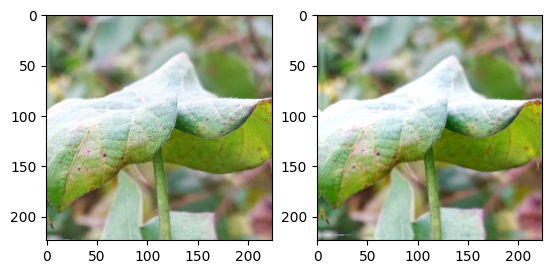

In [ ]:
# Augmentation pipeline
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
])

# Visualize original and augmented images
_, axs = plt.subplots(1, 2)
for images, labels in train_data.take(1):
    axs[0].imshow(images[0].numpy().astype('uint8'))
    img = AUG(images[0], training=True)
    axs[1].imshow(img.numpy().astype('uint8'))
plt.show()

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            augmented_images.extend([image, aug_img])
            augmented_labels.extend([label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

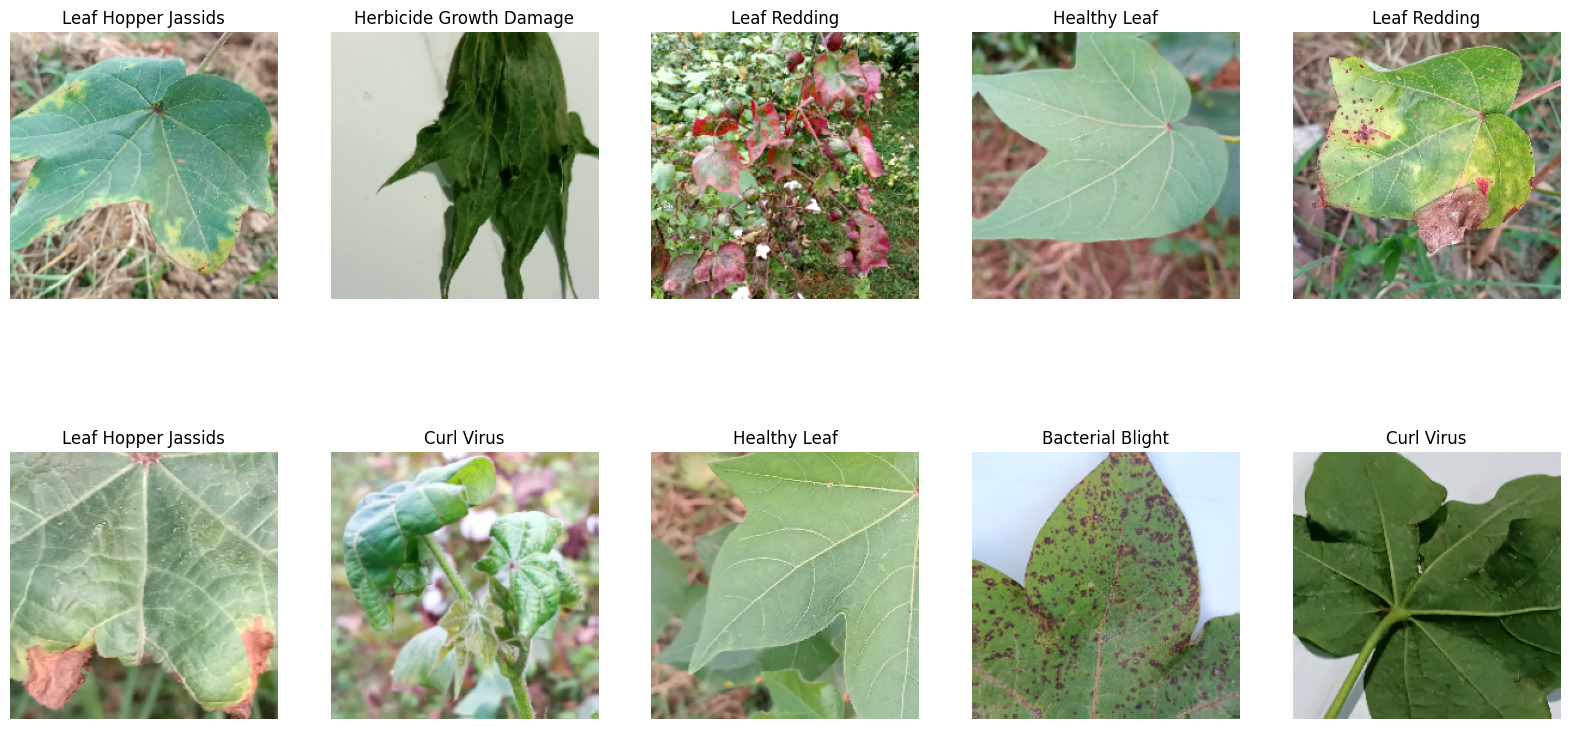

Original train data class counts: {'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208, 'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176, 'Leaf Redding': 458, 'Leaf Variegation': 87}
Augmented train data class counts: {'Bacterial Blight': 410, 'Curl Virus': 714, 'Healthy Leaf': 416, 'Herbicide Growth Damage': 438, 'Leaf Hopper Jassids': 352, 'Leaf Redding': 916, 'Leaf Variegation': 174}


In [ ]:
show_images(training_aug_data)

print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
def preprocess_input(image, label):
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Compute class weights for imbalance
class_counts = {
    'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208,
    'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176,
    'Leaf Redding': 458, 'Leaf Variegation': 87
}
labels = []
for name, count in class_counts.items():
    label_idx = class_names.index(name)
    labels.extend([label_idx] * count)
labels = tf.convert_to_tensor(labels)
class_weights = compute_class_weight('balanced', classes=tf.unique(labels)[0].numpy(), y=labels.numpy())
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1916376306620209), 1: np.float64(0.6842737094837935), 2: np.float64(1.1744505494505495), 3: np.float64(1.1154598825831703), 4: np.float64(1.3879870129870129), 5: np.float64(0.5333749220212103), 6: np.float64(2.8078817733990147)}


Total 30 Epochs:

In [ ]:
# Load MobileNetV3Small model
base_model = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,238,135 (4.72 MB)

 Trainable params: 299,015 (1.14 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 105s 869ms/step - accuracy: 0.6384 - loss: 1.0203 - val_accuracy: 0.9461 - val_loss: 0.2564
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 47s 38ms/step - accuracy: 0.9037 - loss: 0.2720 - val_accuracy: 0.9180 - val_loss: 0.2544
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.9254 - loss: 0.1866 - val_accuracy: 0.9438 - val_loss: 0.1805
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9525 - loss: 0.1305 - val_accuracy: 0.9227 - val_loss: 0.2249
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.9547 - loss: 0.1197 - val_accuracy: 0.9555 - val_loss: 0.1588
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 38ms/step - accuracy: 0.9742 - loss: 0.0754 - val_accuracy: 0.9555 - val_loss: 0.1528
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.9758 - loss: 0.0671 - val_accuracy: 0.9532 - val_loss: 0.1470
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9699 - loss: 0.0690 - val_

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 36s 195ms/step - accuracy: 0.9853 - loss: 0.0421 - val_accuracy: 0.9578 - val_loss: 0.1505
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 19s 47ms/step - accuracy: 0.9921 - loss: 0.0240 - val_accuracy: 0.9602 - val_loss: 0.1371
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9933 - loss: 0.0175 - val_accuracy: 0.9742 - val_loss: 0.1317
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - accuracy: 0.9948 - loss: 0.0127 - val_accuracy: 0.9742 - val_loss: 0.1136
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9957 - loss: 0.0110 - val_accuracy: 0.9696 - val_loss: 0.1439
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9696 - val_loss: 0.1256
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9963 - loss: 0.0145 - val_accuracy: 0.9625 - val_loss: 0.1317
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - acc

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9660 - loss: 0.2216
Validation loss: 0.1591, Validation accuracy: 0.9766
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.92      1.00      0.96        45
             Curl Virus       0.99      1.00      0.99        74
           Healthy Leaf       0.96      0.98      0.97        49
Herbicide Growth Damage       1.00      0.98      0.99

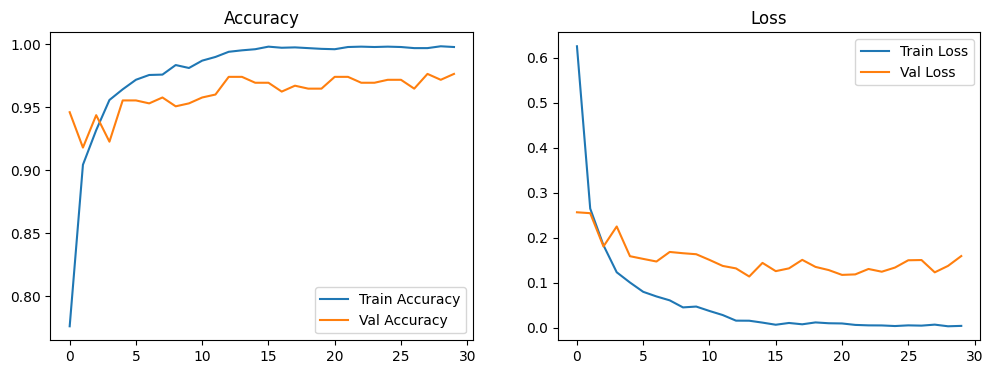

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

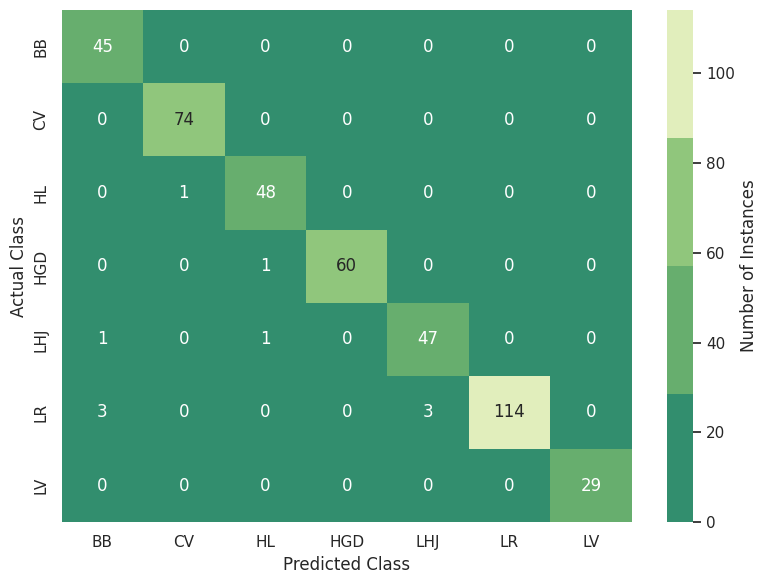

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   1,  60,   0,   0,   0],
 [  1,   0,   1,   0,  47,   0,   0],
 [  3,   0,   0,   0,   3, 114,   0],
 [  0,   0,   0,   0,   0,   0,  29]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

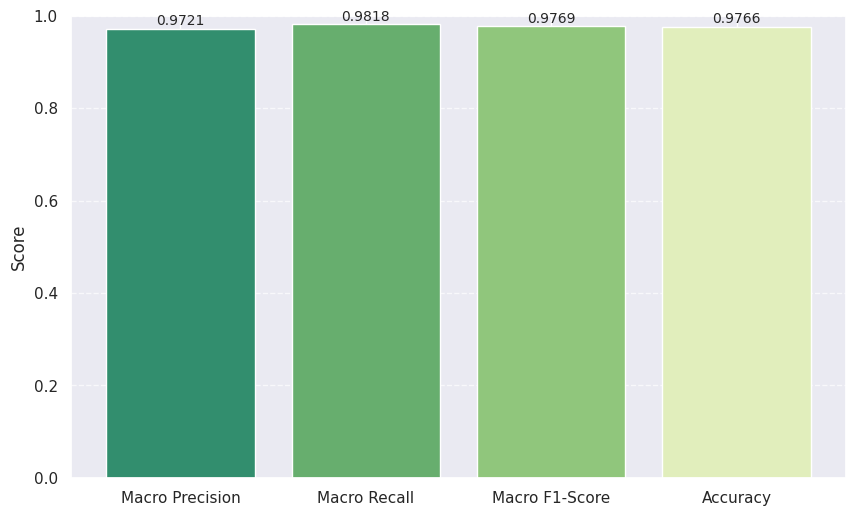

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   1,  60,   0,   0,   0],
 [  1,   0,   1,   0,  47,   0,   0],
 [  3,   0,   0,   0,   3, 114,   0],
 [  0,   0,   0,   0,   0,   0,  29]
  ])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZC_FT40DL] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40DL_MobileNetV3Small_evaluation_metrics[RandZC].png')

Total 60 Epochs:

In [ ]:
# Load MobileNetV3Small model
base_model = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,238,135 (4.72 MB)

 Trainable params: 299,015 (1.14 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 95s 774ms/step - accuracy: 0.6477 - loss: 0.9871 - val_accuracy: 0.9157 - val_loss: 0.2743
Epoch 2/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - accuracy: 0.9001 - loss: 0.2744 - val_accuracy: 0.9344 - val_loss: 0.1939
Epoch 3/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.9327 - loss: 0.1882 - val_accuracy: 0.9438 - val_loss: 0.1797
Epoch 4/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9544 - loss: 0.1235 - val_accuracy: 0.9485 - val_loss: 0.1883
Epoch 5/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9597 - loss: 0.0992 - val_accuracy: 0.9555 - val_loss: 0.1504
Epoch 6/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.9721 - loss: 0.0739 - val_accuracy: 0.9508 - val_loss: 0.1565
Epoch 7/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.9835 - loss: 0.0559 - val_accuracy: 0.9578 - val_loss: 0.1539
Epoch 8/20
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9833 - loss: 0.0569 - val_ac

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=40,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 35s 181ms/step - accuracy: 0.9894 - loss: 0.0261 - val_accuracy: 0.9602 - val_loss: 0.1611
Epoch 2/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.9943 - loss: 0.0168 - val_accuracy: 0.9649 - val_loss: 0.1365
Epoch 3/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 8s 46ms/step - accuracy: 0.9988 - loss: 0.0060 - val_accuracy: 0.9672 - val_loss: 0.1524
Epoch 4/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - accuracy: 0.9962 - loss: 0.0137 - val_accuracy: 0.9555 - val_loss: 0.1675
Epoch 5/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.9986 - loss: 0.0060 - val_accuracy: 0.9602 - val_loss: 0.1481
Epoch 6/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9975 - loss: 0.0111 - val_accuracy: 0.9625 - val_loss: 0.1464
Epoch 7/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.9975 - loss: 0.0073 - val_accuracy: 0.9578 - val_loss: 0.1663
Epoch 8/40
107/107 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accura

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 0.9569 - loss: 0.2338
Validation loss: 0.1692, Validation accuracy: 0.9719
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.94      1.00      0.97        45
             Curl Virus       0.96      1.00      0.98        74
           Healthy Leaf       0.98      0.98      0.98        49
Herbicide Growth Damage       0.98      0.97      0.98   

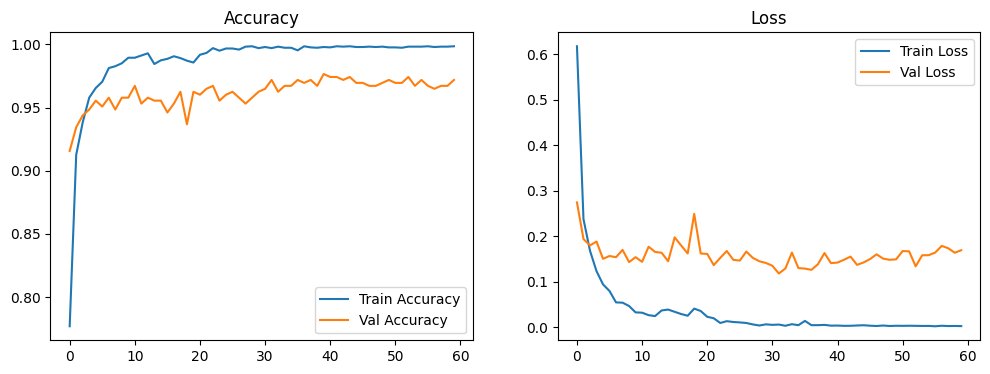

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

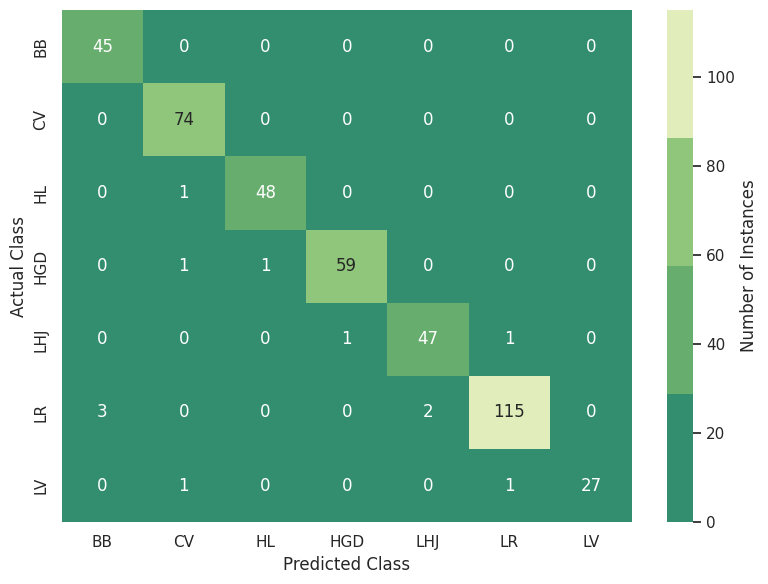

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   1,   1,  59,   0,   0,   0],
 [  0,   0,   0,   1,  47,   1,   0],
 [  3,   0,   0,   0,   2, 115,   0],
 [  0,   1,   0,   0,   0,   1,  27],
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

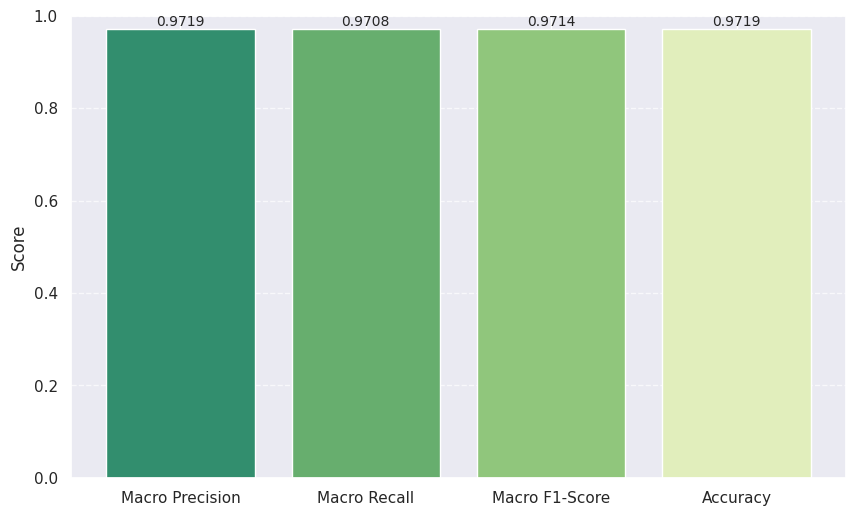

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0,   0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   1,   1,  59,   0,   0,   0],
 [  0,   0,   0,   1,  47,   1,   0],
 [  3,   0,   0,   0,   2, 115,   0],
 [  0,   1,   0,   0,   0,   1,  27]
  ])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandZC_FT40DL] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40DL_MobileNetV3Small_evaluation_metrics[RandZC].png')

# Double Augmentation:

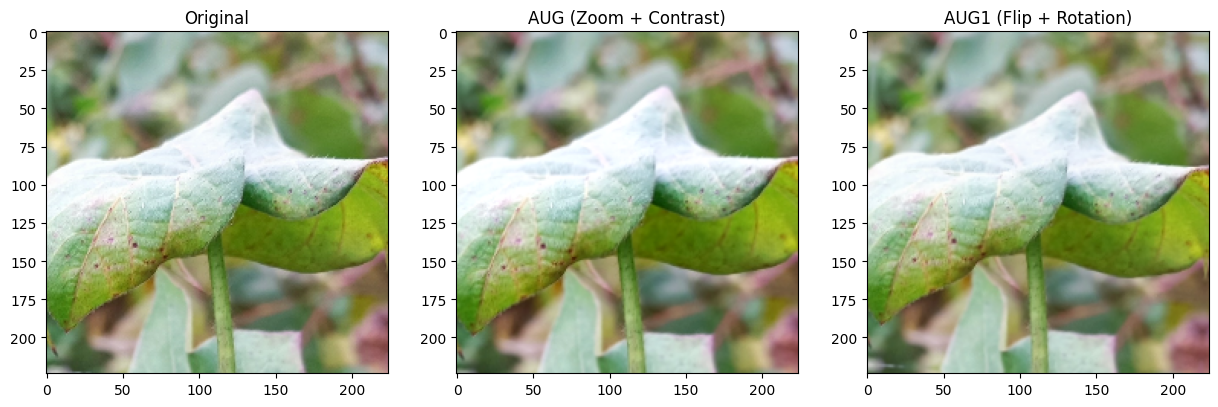

In [ ]:
# Augmentation pipelines
AUG = tf.keras.Sequential([
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.15),
])

AUG1 = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
])

# Visualize original and augmented images
def visualize_augmentation(dataset):
    _, axs = plt.subplots(1, 3, figsize=(15, 5))
    for images, labels in dataset.take(1):
        img = images[0]
        axs[0].imshow(img.numpy().astype('uint8'))
        axs[0].set_title("Original")
        axs[1].imshow(AUG(img, training=True).numpy().astype('uint8'))
        axs[1].set_title("AUG (Zoom + Contrast)")
        axs[2].imshow(AUG1(img, training=True).numpy().astype('uint8'))
        axs[2].set_title("AUG1 (Flip + Rotation)")
        plt.show()

visualize_augmentation(train_data)

In [ ]:
# Augmentation function
def augment_data(dataset):
    augmented_images = []
    augmented_labels = []
    for images, labels in dataset:
        for idx in range(len(images)):
            image = images[idx]
            label = labels[idx]
            aug_img = AUG(image, training=True)
            aug_img1 = AUG1(image, training=True)
            augmented_images.extend([image, aug_img, aug_img1])
            augmented_labels.extend([label, label, label])
    return augmented_images, augmented_labels


augmented_images, augmented_labels = augment_data(train_data)
training_aug_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))
training_aug_data = training_aug_data.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

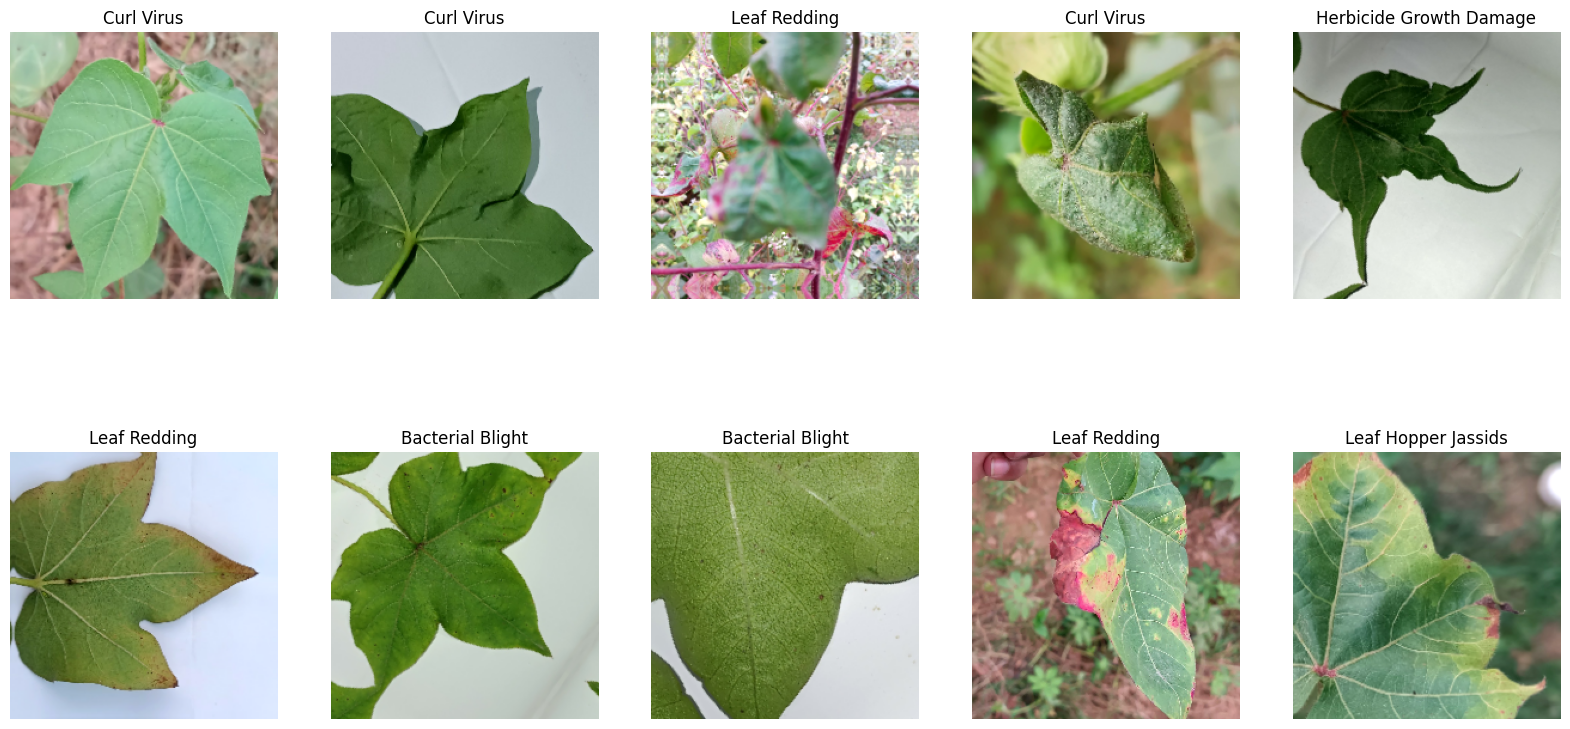

Original train data class counts: {'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208, 'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176, 'Leaf Redding': 458, 'Leaf Variegation': 87}
Augmented train data class counts: {'Bacterial Blight': 615, 'Curl Virus': 1071, 'Healthy Leaf': 624, 'Herbicide Growth Damage': 657, 'Leaf Hopper Jassids': 528, 'Leaf Redding': 1374, 'Leaf Variegation': 261}


In [ ]:
show_images(training_aug_data)

print(f"Original train data class counts: {count_samples_per_class(train_data)}")
print(f"Augmented train data class counts: {count_samples_per_class(training_aug_data)}")

In [ ]:
def preprocess_input(image, label):
    image = tf.keras.applications.mobilenet_v3.preprocess_input(image)
    return image, label

training_aug_data = training_aug_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(preprocess_input, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Compute class weights for imbalance
class_counts = {
    'Bacterial Blight': 205, 'Curl Virus': 357, 'Healthy Leaf': 208,
    'Herbicide Growth Damage': 219, 'Leaf Hopper Jassids': 176,
    'Leaf Redding': 458, 'Leaf Variegation': 87
}
labels = []
for name, count in class_counts.items():
    label_idx = class_names.index(name)
    labels.extend([label_idx] * count)
labels = tf.convert_to_tensor(labels)
class_weights = compute_class_weight('balanced', classes=tf.unique(labels)[0].numpy(), y=labels.numpy())
class_weight_dict = dict(enumerate(class_weights))
print("Class weights:", class_weight_dict)

Class weights: {0: np.float64(1.1916376306620209), 1: np.float64(0.6842737094837935), 2: np.float64(1.1744505494505495), 3: np.float64(1.1154598825831703), 4: np.float64(1.3879870129870129), 5: np.float64(0.5333749220212103), 6: np.float64(2.8078817733990147)}


Total 30 Epochs:

In [ ]:
# Load MobileNetV3Small model
base_model = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,238,135 (4.72 MB)

 Trainable params: 299,015 (1.14 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=10,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 105s 572ms/step - accuracy: 0.6720 - loss: 0.8960 - val_accuracy: 0.9110 - val_loss: 0.2929
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 49s 32ms/step - accuracy: 0.9051 - loss: 0.2435 - val_accuracy: 0.9485 - val_loss: 0.1899
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9398 - loss: 0.1481 - val_accuracy: 0.9368 - val_loss: 0.1959
Epoch 4/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9542 - loss: 0.1282 - val_accuracy: 0.9391 - val_loss: 0.1863
Epoch 5/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - accuracy: 0.9654 - loss: 0.0834 - val_accuracy: 0.9508 - val_loss: 0.1538
Epoch 6/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9705 - loss: 0.0800 - val_accuracy: 0.9602 - val_loss: 0.1390
Epoch 7/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9786 - loss: 0.0581 - val_accuracy: 0.9602 - val_loss: 0.1345
Epoch 8/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9846 - loss: 0.0477 - va

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 38s 136ms/step - accuracy: 0.9868 - loss: 0.0340 - val_accuracy: 0.9602 - val_loss: 0.1338
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.9944 - loss: 0.0158 - val_accuracy: 0.9649 - val_loss: 0.1410
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.9956 - loss: 0.0123 - val_accuracy: 0.9696 - val_loss: 0.1356
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9962 - loss: 0.0108 - val_accuracy: 0.9602 - val_loss: 0.1371
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9969 - loss: 0.0100 - val_accuracy: 0.9508 - val_loss: 0.1701
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9947 - loss: 0.0146 - val_accuracy: 0.9555 - val_loss: 0.1619
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9956 - loss: 0.0081 - val_accuracy: 0.9649 - val_loss: 0.1241
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accur

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9687 - loss: 0.1708
Validation loss: 0.1386, Validation accuracy: 0.9742
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.88      1.00      0.94        45
             Curl Virus       0.99      1.00      0.99        74
           Healthy Leaf       0.98      0.98      0.98        49
Herbicide Growth Damage       1.00      1.00      1.0

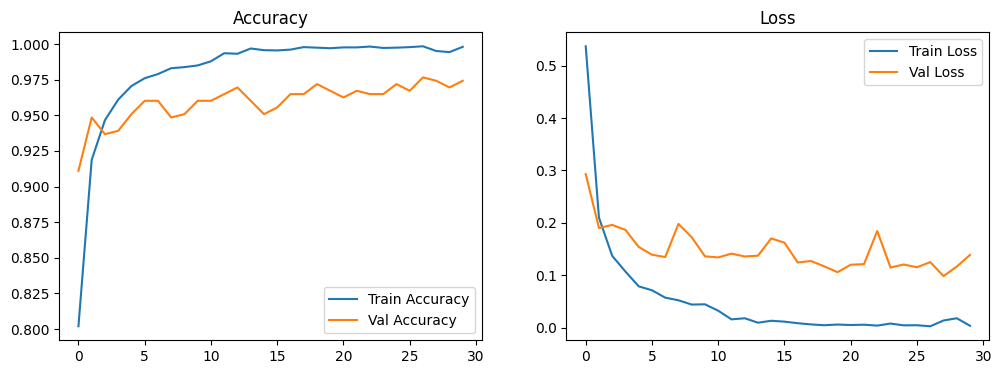

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

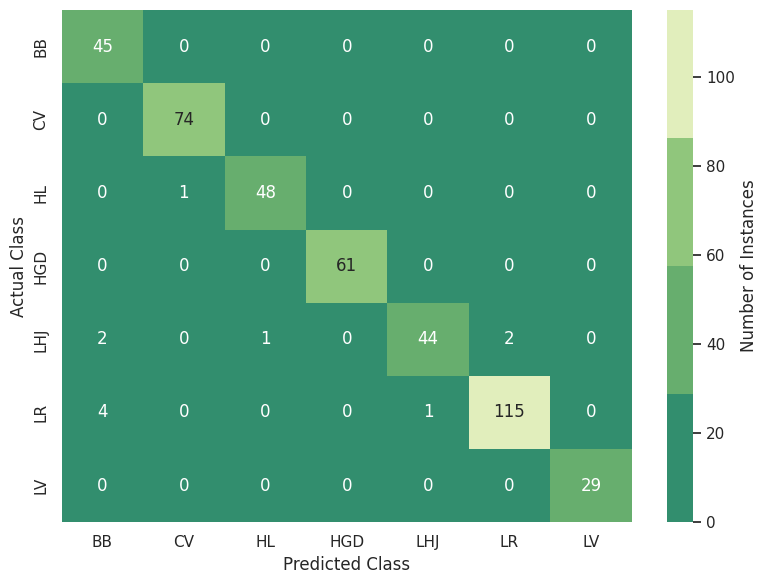

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0 ,  0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  44,   2,   0],
 [  4,   0,   0,   0,   1, 115,   0],
 [  0,   0,   0,   0,   0,   0,  29]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

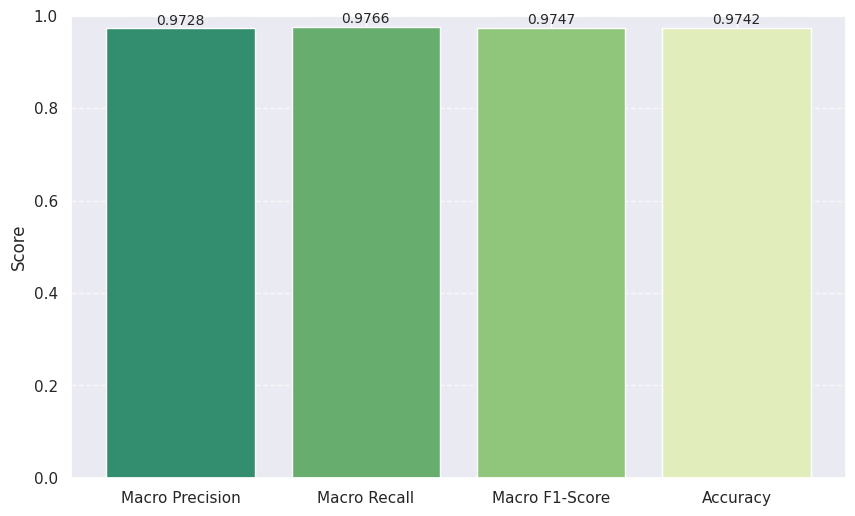

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0 ,  0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  44,   2,   0],
 [  4,   0,   0,   0,   1, 115,   0],
 [  0,   0,   0,   0,   0,   0,  29]
  ])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandFR_ZC_FT40DL] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40DL_MobileNetV3Small_evaluation_metrics[RandFR_ZC].png')

Total 60 Epochs:

In [ ]:
# Load MobileNetV3Small model
base_model = tf.keras.applications.MobileNetV3Small(
    weights='imagenet',
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
output = tf.keras.layers.Dense(len(class_names), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,238,135 (4.72 MB)

 Trainable params: 299,015 (1.14 MB)

 Non-trainable params: 939,120 (3.58 MB)

In [ ]:
# Stage 1: Train top layers
history = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=20,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 82s 416ms/step - accuracy: 0.6942 - loss: 0.8430 - val_accuracy: 0.9227 - val_loss: 0.2346
Epoch 2/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - accuracy: 0.9084 - loss: 0.2444 - val_accuracy: 0.9321 - val_loss: 0.2099
Epoch 3/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9387 - loss: 0.1565 - val_accuracy: 0.9251 - val_loss: 0.1949
Epoch 4/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 36ms/step - accuracy: 0.9568 - loss: 0.1178 - val_accuracy: 0.9532 - val_loss: 0.1610
Epoch 5/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9638 - loss: 0.1025 - val_accuracy: 0.9485 - val_loss: 0.1615
Epoch 6/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.9776 - loss: 0.0591 - val_accuracy: 0.9508 - val_loss: 0.1625
Epoch 7/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - accuracy: 0.9787 - loss: 0.0570 - val_accuracy: 0.9532 - val_loss: 0.1573
Epoch 8/20
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.9817 - loss: 0.0471 - val_

In [ ]:
# Stage 2: Fine-tune last 40 layers (exclude BatchNormalization)
for layer in base_model.layers[-40:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Re-compile for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Fine-tuning the last 40 layers...")
history_stage2 = model.fit(
    training_aug_data,
    validation_data=val_data,
    epochs=40,
    verbose=1,
    class_weight=class_weight_dict
)

Fine-tuning the last 40 layers...
Epoch 1/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 39s 136ms/step - accuracy: 0.9898 - loss: 0.0252 - val_accuracy: 0.9742 - val_loss: 0.1133
Epoch 2/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.9954 - loss: 0.0121 - val_accuracy: 0.9649 - val_loss: 0.1673
Epoch 3/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9941 - loss: 0.0249 - val_accuracy: 0.9742 - val_loss: 0.1267
Epoch 4/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - accuracy: 0.9945 - loss: 0.0106 - val_accuracy: 0.9696 - val_loss: 0.1332
Epoch 5/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9976 - loss: 0.0082 - val_accuracy: 0.9719 - val_loss: 0.1440
Epoch 6/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9983 - loss: 0.0036 - val_accuracy: 0.9649 - val_loss: 0.1635
Epoch 7/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - accuracy: 0.9977 - loss: 0.0070 - val_accuracy: 0.9719 - val_loss: 0.1336
Epoch 8/40
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - acc

In [ ]:
# Evaluate model
val_results = model.evaluate(val_data)
print(f"Validation loss: {val_results[0]:.4f}, Validation accuracy: {val_results[1]:.4f}")

# Generate classification report and confusion matrix
y_val_true = []
y_val_pred = []
for images, labels in val_data:
    y_val_true.extend(tf.argmax(labels, axis=1).numpy())
    y_val_pred.extend(tf.argmax(model.predict(images), axis=1))

print("Classification Report:")
print(classification_report(y_val_true, y_val_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_val_true, y_val_pred))

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9647 - loss: 0.1918
Validation loss: 0.1293, Validation accuracy: 0.9742
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report:
                         precision    recall  f1-score   support

       Bacterial Blight       0.90      0.98      0.94        45
             Curl Virus       0.96      1.00      0.98        74
           Healthy Leaf       1.00      0.98      0.99        49
Herbicide Growth Damage       1.00      1.00      1.

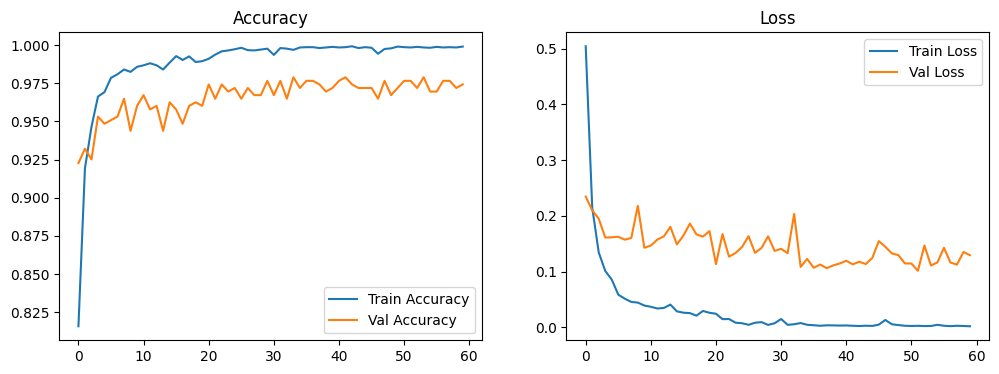

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_stage2.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_stage2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_stage2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_stage2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

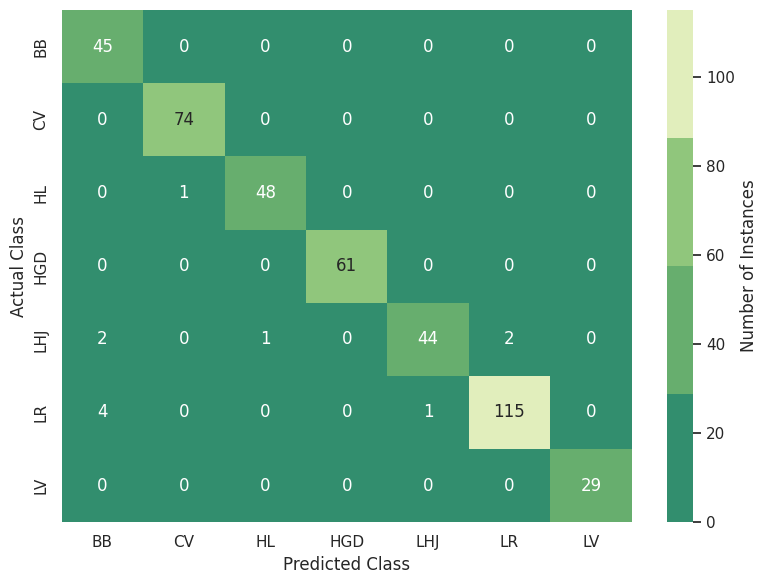

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Define the confusion matrix
confusion_matrix = np.array([
    [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0 ,  0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  44,   2,   0],
 [  4,   0,   0,   0,   1, 115,   0],
 [  0,   0,   0,   0,   0,   0,  29]
])

# Define class names and their abbreviations
class_names = [
    'Bacterial Blight', 'Curl Virus', 'Healthy Leaf', 'Herbicide Growth Damage',
    'Leaf Hopper Jassids', 'Leaf Redding', 'Leaf Variegation'
]
class_abbr = ['BB', 'CV', 'HL', 'HGD', 'LHJ', 'LR', 'LV']

# Define custom colors
colors = ['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC']
custom_cmap = ListedColormap(colors)

# Set up the plot
plt.figure(figsize=(8, 6))
sns.set(font_scale=1)  # Increase font size for readability
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap=custom_cmap,
            xticklabels=class_abbr, yticklabels=class_abbr,
            cbar_kws={'label': 'Number of Instances'})
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
# plt.title('Confusion Matrix for Cotton Leaf Disease Classification\n(ResNet50, Dual Augmentation, 40 layers, dropout=0.4)')
plt.tight_layout()

# Display the plot
plt.show()

# Save the figure
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.close()

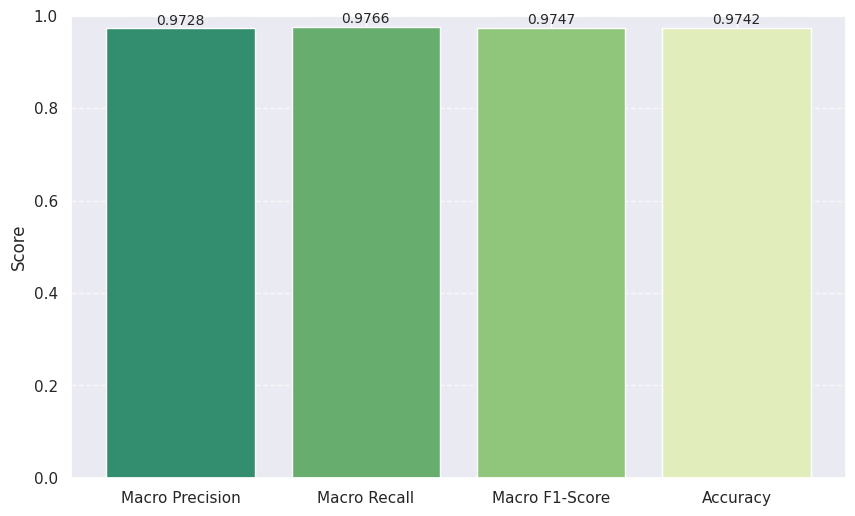

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_metrics(confusion_matrix):
    n_classes = confusion_matrix.shape[0]

    # Initialize variables
    TP = np.zeros(n_classes)
    FP = np.zeros(n_classes)
    FN = np.zeros(n_classes)

    # Calculate TP, FP, FN for each class
    for i in range(n_classes):
        TP[i] = confusion_matrix[i, i]
        FP[i] = np.sum(confusion_matrix[:, i]) - TP[i]
        FN[i] = np.sum(confusion_matrix[i, :]) - TP[i]

    # Calculate macro-average precision, recall, f1-score
    precision = []
    recall = []
    for i in range(n_classes):
        prec = TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0.0
        rec = TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0.0
        precision.append(prec)
        recall.append(rec)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall) if (macro_precision + macro_recall) > 0 else 0.0

    # Calculate overall accuracy
    total_correct = np.sum(TP)
    total_samples = np.sum(confusion_matrix)
    accuracy = total_correct / total_samples if total_samples > 0 else 0.0

    return macro_precision, macro_recall, macro_f1, accuracy

# Provided confusion matrix
confusion_matrix = np.array([
  [ 45,   0,   0,   0,   0,   0,   0],
 [  0,  74,   0,   0,   0 ,  0,   0],
 [  0,   1,  48,   0,   0,   0,   0],
 [  0,   0,   0,  61,   0,   0,   0],
 [  2,   0,   1,   0,  44,   2,   0],
 [  4,   0,   0,   0,   1, 115,   0],
 [  0,   0,   0,   0,   0,   0,  29]
  ])

# Calculate metrics
macro_precision, macro_recall, macro_f1, accuracy = calculate_metrics(confusion_matrix)

# Create bar chart
metrics = ['Macro Precision', 'Macro Recall', 'Macro F1-Score', 'Accuracy']
values = [macro_precision, macro_recall, macro_f1, accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['#328E6E', '#67AE6E', '#90C67C', '#E1EEBC'])
plt.ylim(0, 1)
# plt.title('Evaluation Metrics [RandFR_ZC_FT40DL] from Confusion Matrix', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.001, f'{yval:.4f}',
             ha='center', va='bottom', fontsize=10)

plt.savefig('FT40DL_MobileNetV3Small_evaluation_metrics[RandFR_ZC].png')